# Converting netCDF images to timeseries format

For many analyses and for validation of data record, it is necessary to access time series of data for a given location. Unfortunately, satellite or model data is often supplied as "images", i.e. slices along the spatial dimension for a single time.

`qa4sm_preprocessing.reading` provides utilities to reformat directories of image netCDF files or single netCDF files consisting of a stack of images to formats more suitable for timeseries access, e.g. the `pynetcf` timeseries format or transposed netCDF files with time as last dimension.

As an example, consider the following model output files:

In [1]:
%ls ../../tests/test-data/preprocessing/lis_noahmp/*

../../tests/test-data/preprocessing/lis_noahmp/201703:
LIS_HIST_201703300000.d01.nc  LIS_HIST_201703310000.d01.nc

../../tests/test-data/preprocessing/lis_noahmp/201704:
LIS_HIST_201704010000.d01.nc  LIS_HIST_201704030000.d01.nc
LIS_HIST_201704020000.d01.nc  LIS_HIST_201704040000.d01.nc


The relevant files are in nested directories, and have filenames that contain the timestamp. We can open one such file to see what's inside:

In [2]:
import xarray as xr
xr.open_dataset("../../tests/test-data/preprocessing/lis_noahmp/201703/LIS_HIST_201703300000.d01.nc")

<xarray.Dataset>
Dimensions:         (north_south: 100, east_west: 50, SoilMoist_profiles: 4,
                     time: 1)
Coordinates:
  * time            (time) datetime64[ns] 2017-03-30
Dimensions without coordinates: north_south, east_west, SoilMoist_profiles
Data variables:
    lat             (north_south, east_west) float32 ...
    lon             (north_south, east_west) float32 ...
    SoilMoist_inst  (SoilMoist_profiles, north_south, east_west) float32 ...
Attributes: (12/17)
    CDI:                     Climate Data Interface version 1.9.9rc1 (https:/...
    Conventions:             CF-1.6
    history:                 Tue Aug 03 15:32:25 2021: cdo -selindexbox,1,50,...
    institution:             NASA GSFC
    missing_value:           -9999.0
    NUM_SOIL_LAYERS:         4
    ...                      ...
    MAP_PROJECTION:          EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:   29.875
    SOUTH_WEST_CORNER_LON:   -11.375
    DX:                      0.25
    DY:                      0.25
    CDO:                     Climate Data Operators version 1.9.9rc1 (https:/...

As we can see, there are lots of variables and dimensions. If we are interested in surface soil moisture, the variable of interest is "SoilMoist_inst" with the level dimension "SoilMoist_profiles" = 0. Another complicating factor is that the spatial dimensions "east_west" and "north_south" are not directly linked to latitude and longitude values.
However, the metadata contain the fields "SOUTH_WEST_CORNER_LAT", "SOUTH_WEST_CORNER_LON", "DX", and "DY", from which we can reconstruct the latitude and longitude values.

All of this can be done with the `DirectoryImageReader`.

### DirectoryImageReader

In [3]:
# first we have to derive the latitude and longitude of the northeast corner
sw_corner_lat = 29.875
sw_corner_lon = -11.375
print("Northeast corner lat", sw_corner_lat + 100*0.25)
print("Northeast corner lon", sw_corner_lon + 50*0.25)

Northeast corner lat 54.875
Northeast corner lon 1.125


In [7]:
from qa4sm_preprocessing.reading import DirectoryImageReader
import numpy as np

reader = DirectoryImageReader(
    "../../tests/test-data/preprocessing/lis_noahmp",   # the directory containing the files
    "SoilMoist_inst",                                   # the variable of interest
    pattern="**/LIS_HIST_*.nc",                         # pattern to match, to exclude files
    fmt="LIS_HIST_%Y%m%d%H%M.d01.nc",                   # format string to deduce timestamps
    rename={"north_south": "lat", "east_west": "lon"},  # renaming of dimensions
    level={"SoilMoist_profiles": 0},                    # selection of level of interest
    lat=np.arange(29.875, 54.875, 0.25),                # specification of latitude vector
    lon=np.arange(-11.375, 1.125, 0.25)                 # specification of longitude vector
)

With this reader we can either read `pygeobase` images, or images as `xr.Dataset`. The latter allows for easy plotting of images.

In [8]:
reader.read("2017-03-30")

Automatic pdb calling has been turned OFF


  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
reader.read_block("2017-03-30", "2017-03-30")

  0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:         (time: 1, lat: 100, lon: 50)
Coordinates:
  * time            (time) datetime64[ns] 2017-03-30
  * lat             (lat) float64 29.88 30.12 30.38 30.62 ... 54.12 54.38 54.62
  * lon             (lon) float64 -11.38 -11.12 -10.88 ... 0.375 0.625 0.875
Data variables:
    SoilMoist_inst  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/17)
    CDI:                     Climate Data Interface version 1.9.9rc1 (https:/...
    Conventions:             CF-1.6
    history:                 Tue Aug 03 15:32:25 2021: cdo -selindexbox,1,50,...
    institution:             NASA GSFC
    missing_value:           -9999.0
    NUM_SOIL_LAYERS:         4
    ...                      ...
    MAP_PROJECTION:          EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:   29.875
    SOUTH_WEST_CORNER_LON:   -11.375
    DX:                      0.25
    DY:                      0.25
    CDO:                     Climate Data Operators version 1.9.9rc1 (https:/...

  0%|          | 0/1 [00:00<?, ?it/s]

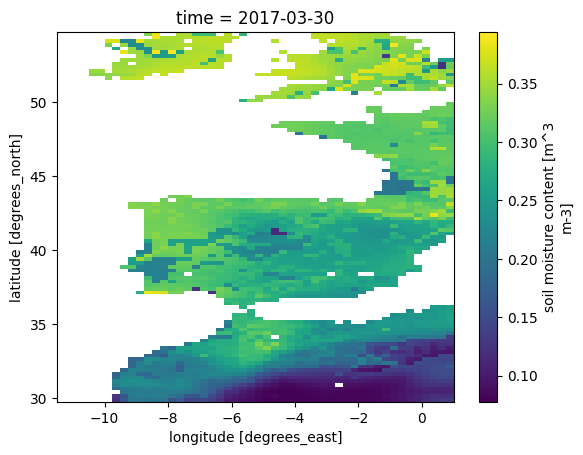

In [10]:
reader.read_block("2017-03-30", "2017-03-30")["SoilMoist_inst"].plot()

## Image to timeseries

To construct timeseries, you can pass the `DirectoryImageReader` instance to `repurpose` in your own Python code, or you can use the `repurpose_images` script. This script provides all the options that the DirectoryImageReader also provides.

In [11]:
%%bash

time repurpose_images\
    --parameter SoilMoist_inst\
    --pattern '**/LIS_HIST_*.nc'\
    --time_fmt "LIS_HIST_%Y%m%d%H%M.d01.nc"\
    --rename "north_south:lat" "east_west:lon"\
    --lat "29.875" "54.875" "0.25"\
    --lon "-11.375" "1.125" "0.25"\
    --level "SoilMoist_profiles:0"\
    --\
    "../../tests/test-data/preprocessing/lis_noahmp"\
    "../../tests/test-data/preprocessing/lis_noahmp_timeseries"\
    "2017-03-30"\
    "2017-04-04"

Converting data from 2017-03-30 00:00:00 to 2017-04-04 00:00:00 into directory ../../tests/test-data/preprocessing/lis_noahmp_timeseries.



real	0m1,084s
user	0m1,398s
sys	0m1,814s


None <class 'pynetcf.time_series.OrthoMultiTs'>
after <pynetcf.time_series.OrthoMultiTs object at 0x7f8f541b31f0>


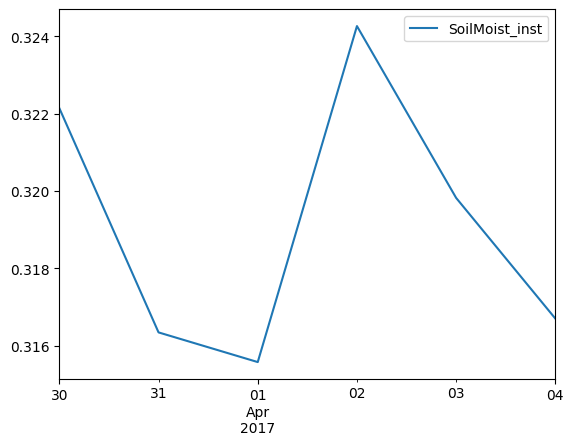

In [12]:
from qa4sm_preprocessing.reading import GriddedNcOrthoMultiTs

reader = GriddedNcOrthoMultiTs("../../tests/test-data/preprocessing/lis_noahmp_timeseries")
ts = reader.read(16.375, 48.125)
ts.plot();